In [31]:
import os
import sys
import math
import copy
import cmath

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *

from libra_py import units
import libra_py.workflows.nbra.step4 as step4
from libra_py import ft
from libra_py import data_conv


import matplotlib.pyplot as plt   # plots
%matplotlib inline 

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

In [32]:
def gen_data(nsteps):
    rnd = Random()

    w1 = 100.0 * units.inv_cm2Ha  # in cm^-1
    w2 = 250.0 * units.inv_cm2Ha  # in cm^-1
    w3 = 300.0 * units.inv_cm2Ha  # in cm^-1
    dt = 1.0 * units.fs2au

    # Populate Hvib - this is our model
    Hvib = []
    hvib = []
    for i in xrange(nsteps):        
        hvib.append(CMATRIX(2,2))
    
        t = dt*i

        e0 = 0.05*math.sin(w1*t)
        e1 = 0.1 + 0.02*math.sin(w2*t) + 0.01 * rnd.uniform(-1.0, 1.0)
        d  = 0.01*math.sin(w3*t) 

        hvib[i].set(0,0,e0*(1.0+0.0j));   hvib[i].set(0,1, d*(0.0-1.0j));
        hvib[i].set(1,0, d*(0.0-1.0j));   hvib[i].set(1,1, e1*(1.0+0.0j));
    Hvib.append(hvib)
        
    return Hvib

In [33]:
nsteps = 500

Hvib = gen_data(nsteps)

dt = 41.0 # a.u.
time1 = []
for i in xrange(nsteps):
    time1.append(i*dt)

In [34]:
tmin = 0.0


wHvib = []
for a in xrange(2):
    for b in xrange(2):
        wHvib.append( CMATRIX(nsteps, 1) )        
        
        h_ab_re = data_conv.unpack1(Hvib[0], a, b, 0)
        h_ab_im = data_conv.unpack1(Hvib[0], a, b, 1)
            
        re = data_conv.list2MATRIX(h_ab_re)
        im = data_conv.list2MATRIX(h_ab_im)
        
        Hvib_ab = CMATRIX(re, im)
        
        cft(Hvib_ab, wHvib[a*2+b], tmin, dt)  

#dw = 1.0/(dt*nsteps)
#w, I = [], []
#for i in xrange(nsteps):
#    w.append(i*dw)
#    c = wHvib.get(i,0)
#    I.append( (c * c.conjugate()).real )

In [35]:
def reconstructH(wHvib, t, dt):    
    N = wHvib[0].num_of_rows
    dw = 1.0/(N*dt)    
        
    h00 = 0.0+0.0j
    h01 = 0.0+0.0j
    h10 = 0.0+0.0j
    h11 = 0.0+0.0j
    for k in xrange(N):
        h00 = h00 + wHvib[0].get(k,0)*cmath.exp(2.0j*math.pi*k*dw*t)
        h01 = h01 + wHvib[1].get(k,0)*cmath.exp(2.0j*math.pi*k*dw*t)
        h10 = h10 + wHvib[2].get(k,0)*cmath.exp(2.0j*math.pi*k*dw*t)
        h11 = h11 + wHvib[3].get(k,0)*cmath.exp(2.0j*math.pi*k*dw*t)
        
    H = CMATRIX(2,2)
    H.set(0,0, h00);   H.set(0,1, h01)
    H.set(1,0, h10);   H.set(1,1, h11)
    H = H * dw
    
    return H

In [36]:
Hrec = []   
time2 = []
for i in xrange(4*nsteps):
    t = i * dt
    time2.append(t)
    Hrec.append( reconstructH(wHvib, t, dt) )

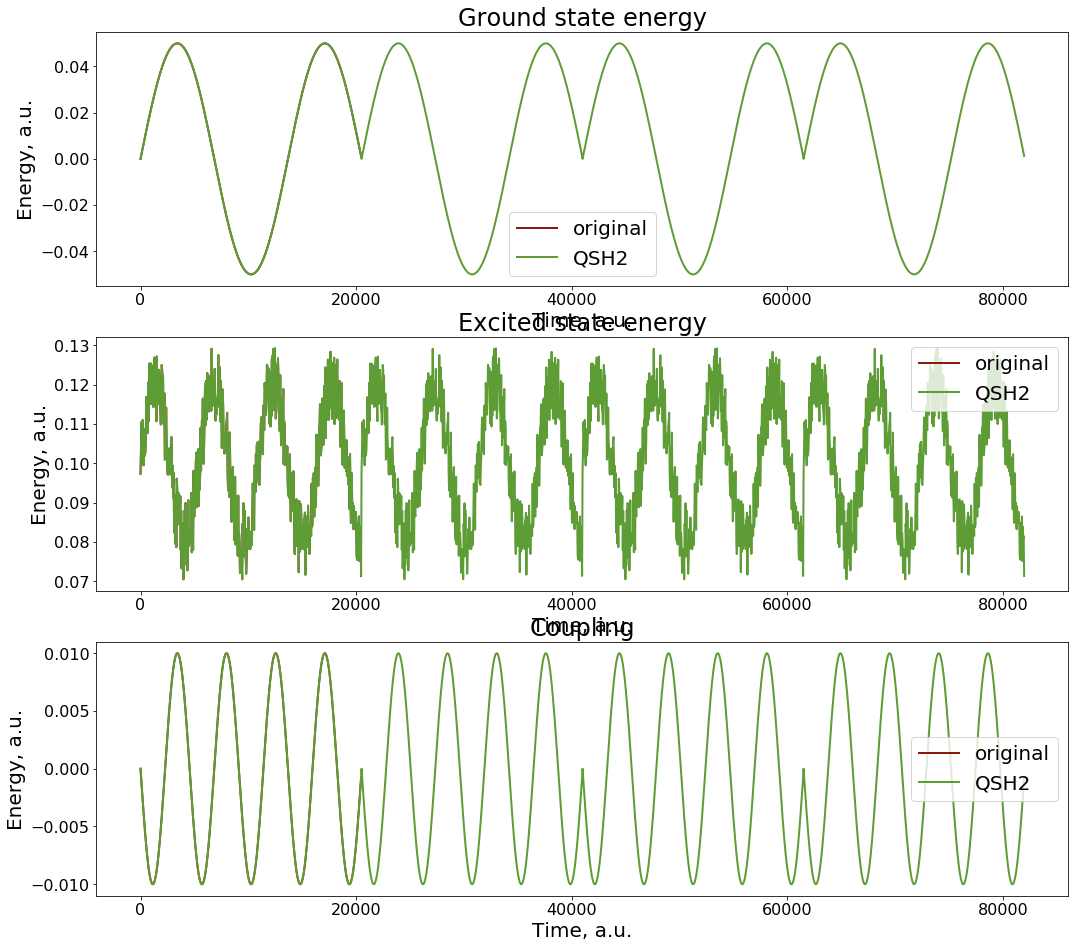

In [37]:
plt.figure(1, figsize=(18, 16)) # dpi=300, frameon=False)
plt.subplot(3,1,1)
plt.title('Ground state energy')
plt.xlabel('Time, a.u.')
plt.ylabel('Energy, a.u.')
plt.plot(time1, data_conv.unpack1(Hvib[0], 0, 0, 0), label='original', linewidth=2, color = colors["11"]) 
plt.plot(time2, data_conv.unpack1(Hrec, 0, 0, 0), label='QSH2', linewidth=2, color = colors["21"]) 
plt.legend()

plt.subplot(3,1,2)
plt.title('Excited state energy')
plt.xlabel('Time, a.u.')
plt.ylabel('Energy, a.u.')
plt.plot(time1, data_conv.unpack1(Hvib[0], 1, 1, 0), label='original', linewidth=2, color = colors["11"]) 
plt.plot(time2, data_conv.unpack1(Hrec, 1, 1, 0), label='QSH2', linewidth=2, color = colors["21"]) 
plt.legend()

plt.subplot(3,1,3)
plt.title('Coupling')
plt.xlabel('Time, a.u.')
plt.ylabel('Energy, a.u.')
plt.plot(time1, data_conv.unpack1(Hvib[0], 0, 1, 1), label='original', linewidth=2, color = colors["11"]) 
plt.plot(time2, data_conv.unpack1(Hrec, 0, 1, 1), label='QSH2', linewidth=2, color = colors["21"]) 
plt.legend()


plt.show()
plt.close()

In [38]:
params1 = {}
params1.update({"T":300.0, "ntraj":250, "sh_method":1, "decoherence_method":1, "dt":41.0})
params1.update({"nsteps":nsteps, "Boltz_opt":1})
params1.update({"istate":1, "init_times":[0], "outfile":"_out.txt"})
params1.update({"data_set_paths":[""]})

In [39]:
res1 = step4.run(Hvib, params1)

Use the default value =  0
Decoherence times matrix (a.u. of time):
Decoherence times matrix (fs):
Decoherence rates matrix (a.u.^-1):


In [40]:
params1["nsteps"] = 4*nsteps
res2 = step4.run([Hrec], params1)

Decoherence times matrix (a.u. of time):
Decoherence times matrix (fs):
Decoherence rates matrix (a.u.^-1):


In [41]:
P0, P1 = [], []
qsh_P0, qsh_P1 = [], []

for i in xrange(nsteps):    
    P0.append(res1.get(i, 2))  # SH pop of state 0
    P1.append(res1.get(i, 5))  # SH pop of state 1

for i in xrange(params1["nsteps"]):
    qsh_P0.append(res2.get(i, 2))  # SH pop of state 0
    qsh_P1.append(res2.get(i, 5))  # SH pop of state 1

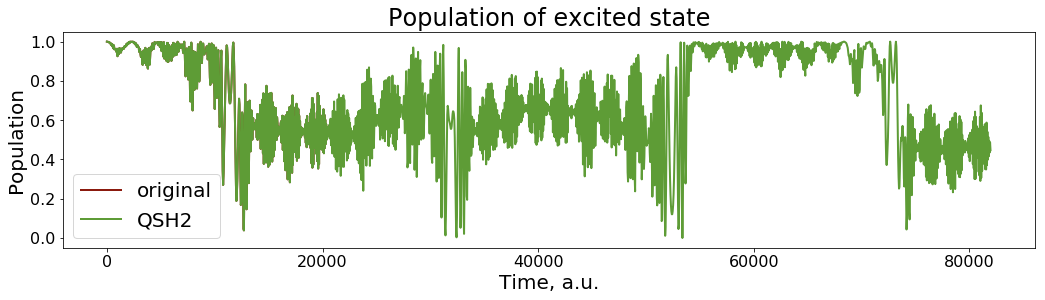

In [42]:
plt.figure(1, figsize=(18, 4)) # dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('Population of excited state')
plt.xlabel('Time, a.u.')
plt.ylabel('Population')
plt.plot(time1, P1, label='original', linewidth=2, color = colors["11"]) 
plt.plot(time2, qsh_P1, label='QSH2', linewidth=2, color = colors["21"]) 
plt.legend()

plt.show()
plt.close()